## Experiment Set-Up

### Problem Description
The following code supports the investigation into designing a Graph Neural Network (GNN) that solves the (theoretical) problem of a tiger on a random walk in a circular area with a radius of 1,000 meters. Within this area, there are 256 uniformly distributed sensors that are triggered if a tiger passes within a set distance (in meters) at least once. Further, the sensors can yield false positives, but not false negatives. The goal is to determine which sensors the tiger visited before wandering out of the area [1].

### Step One
*Objective:* 

Find 256 sensor locations (uniform distribution) in the circular area (r = 1000m).

*Approach:* 

---
Using polar coordinates...
- r: the radial distance from the center (randomly chosen between 0 and 1000m, weighted by r to maintain uniform distribution)
- θ: the angular position (randomly chosen between 0 and 2π radians, uniformly distributed)
---

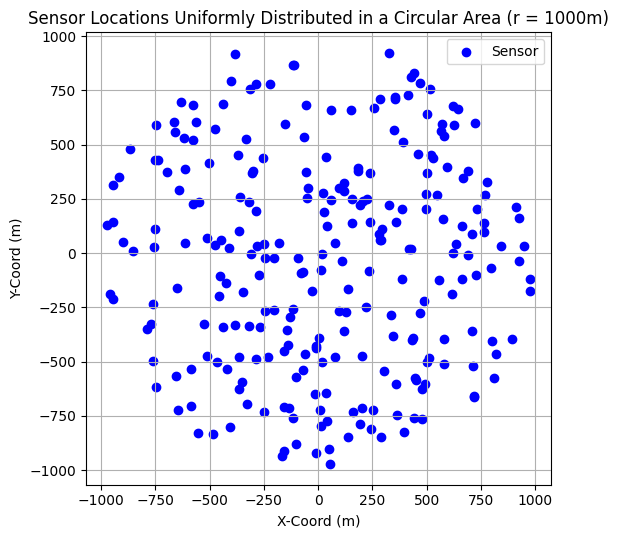

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# sensors & area radius
num_sensors = 256
radius = 1000

# uniform random values for the radius and theta
r = np.sqrt(np.random.uniform(0, 1, num_sensors)) * radius  # scale by r
theta = np.random.uniform(0, 2 * np.pi, num_sensors)  # theta b/w (0, 2pi)

# polar to cartesian
x = r * np.cos(theta)
y = r * np.sin(theta)

# visualise sensor area
plt.figure(figsize=(6,6))
plt.scatter(x, y, c='blue', marker='o', label="Sensor")
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Sensor Locations Uniformly Distributed in a Circular Area (r = 1000m)')
plt.xlabel('X-Coord (m)')
plt.ylabel('Y-Coord (m)')
plt.legend()
plt.grid(True)
plt.show()


### Step Two
*Objective:* 

Find the sensor adjacency matrix if sensors can communicate over u meters.

*Approach:* 

---
Define the adjacency matrix as Aij = 1 if two sensors are within communicating distance of u-meters from one another (i.e., neighbors) and 0 otherwise.
- Calculate pairwise distances between all sensors
- For each pair of sensors, if dist <= u, set adjacency value to 1 (the sensors can communicate) and 0 otherwise.
---

For now we are just initialising...
- Later on, **u will be learned via attention scores (GAT)**, allowing the model to learn which neighbours are important for communication without setting a fixed u. This will make the adjacency matrix non-binary (0/1), but rather learned by attention scores (alpha-ij) to determine how much attention each sensor pays to its neighbours.

Adjacency Matrix:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]

Number of connections per sensor:
 [1 4 5 3 2 3 2 3 1 3 3 2 5 4 5 4 6 2 2 3 4 3 4 1 3 2 3 7 3 4 7 3 3 4 8 6 5
 1 5 2 1 4 7 4 3 4 2 3 3 1 4 1 6 4 5 4 4 4 3 2 2 2 6 1 3 5 1 5 4 7 4 2 6 4
 2 3 3 3 4 6 1 3 4 3 3 1 2 4 4 3 6 2 5 3 3 3 4 1 1 4 3 2 4 3 4 2 8 3 3 1 3
 4 3 5 3 2 4 2 3 3 1 3 6 3 3 3 5 3 8 3 5 3 2 4 7 2 1 3 3 1 4 2 2 2 3 2 3 2
 4 2 6 3 3 3 3 2 2 2 7 4 3 3 4 3 4 4 5 3 2 3 4 2 2 3 4 3 4 5 2 4 3 5 2 3 3
 4 1 5 3 5 3 3 4 3 3 2 2 4 5 6 3 2 3 5 4 2 4 3 7 2 5 2 3 5 1 3 3 5 3 2 5 3
 6 4 2 2 3 3 5 2 4 2 3 4 3 3 5 3 3 1 4 2 2 4 6 1 2 1 3 4 6 5 2 2 2 3]

mean: 3.34375
med: 3.0
min: 1
max: 8
std: 1.489219069680482


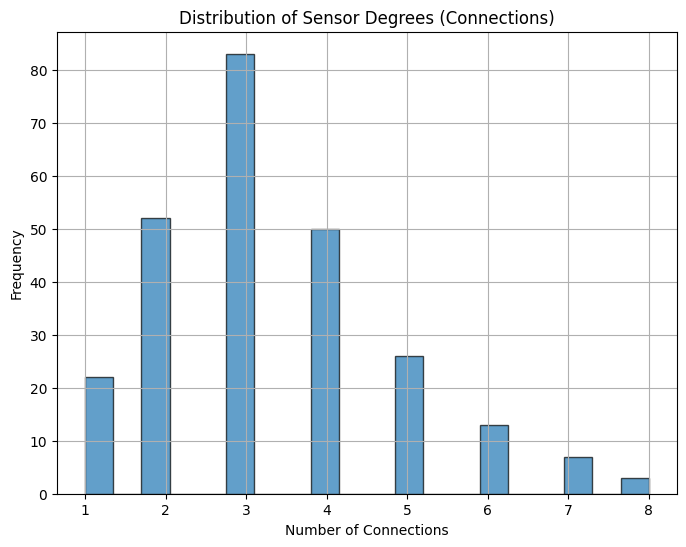

In [29]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

### --- DEFINE ADJACENCY MATRIX ---------------------------------

# u = a communication distance (in meters)
u = 100  # placeholder

# compose x, y coordinates
sensor_positions = np.vstack((x, y)).T

# get pairwise distances between sensors
distances = squareform(pdist(sensor_positions))

# define binary adjacency matrix (1 where dist <= u, else 0)
adjacency_matrix = (distances <= u).astype(int)




### --- INSPECT ADJACENCY MATRIX ---------------------------------

print("Adjacency Matrix:\n", adjacency_matrix)
print("\nNumber of connections per sensor:\n", adjacency_matrix.sum(axis=0))

# connections per sensor (i.e., degree of each sensor)
degrees = np.sum(adjacency_matrix, axis=1) 

degree_stats = {
    '\nmean': np.mean(degrees),
    'med': np.median(degrees),
    'min': np.min(degrees),
    'max': np.max(degrees),
    'std': np.std(degrees)
}
for key, value in degree_stats.items():
    print(f"{key}: {value}")

# distr of sensor degrees
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Sensor Degrees (Connections)')
plt.xlabel('Number of Connections')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Step Three
*Objective:* 

Construct a (nonneural) algorithm to create a dataset of random walks from the center. Check for nearest sensor location after each random-walk step. Make the steps s small so the tiger can’t skip past sensors.

*Approach:* 

---
- Random Walk-1: Tiger initialises atthe origin (0,0).
- Random Walk-2: At each step, the tiger moves s in a small random direction.
- Random Walk-3: Compute new tiger position after each step.
---
- Sensor Check-1: After each move, calculate *d* distance b/w tiger's current position and all sensors.
- Sensor Check-2: Find and record nearest sensor.
---
- Exit Condition: Tiger moves outside of the circle (dist from origin > 1000m)
---

For now we are just initialising...
- Later on, **d will be learned (GAT)**.
- That is - distance can become a trainable parameter (i.e., adjusted to minimise the overall loss function), or it can be learned using the GAT's attention mechanism by adjusting how much attention is given to sensors at varying distances.

Visited sensor indices:
 [119, 164, 119, 164, 70, 119, 119, 119, 70, 207, 97, 97, 207, 170, 147, 170, 97, 207, 131, 99, 131, 131, 147, 131, 120, 248, 131, 220, 90, 248, 120, 120, 120, 248, 20, 168, 20, 44, 120, 168, 120, 120, 248, 120, 82, 120, 147, 170, 97, 119, 173, 119, 173, 173, 96, 126, 130, 173, 70, 97, 119, 214, 228, 51, 147, 170, 97, 70, 152, 152, 126, 164, 45, 77, 45, 58, 158, 153, 153, 22, 228, 22, 22, 111, 184, 184, 31, 7, 21, 52, 140, 209, 209, 125]




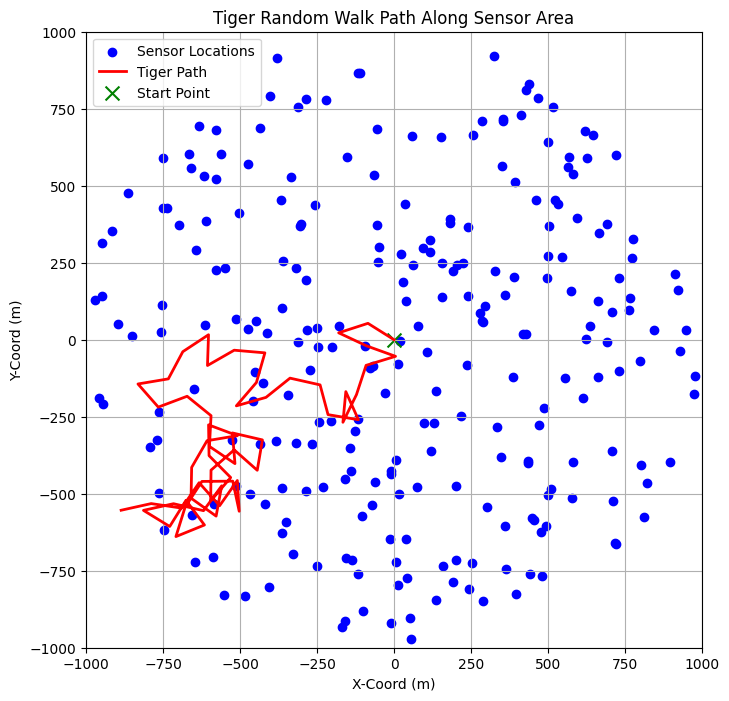

In [31]:
import numpy as np
import matplotlib.pyplot as plt

s = 100  
radius = 1000 
max_steps = 1000  # safeguard

# perform random walk and check for nearest sensor
def random_walk(sensor_positions, s, radius, max_steps):
    # init tiger at origin
    tiger_position = np.array([0.0, 0.0])
    
    visited_sensors = []
    
    for step in range(max_steps):  
        # check exit cond (tiger left circle)
        if np.linalg.norm(tiger_position) > radius:
            break
        
        # move in random direction
        angle = np.random.uniform(0, 2 * np.pi) 
        step_vector = np.array([s * np.cos(angle), s * np.sin(angle)])
        tiger_position += step_vector  # Ensure this is a float operation
        
        # get d from all sensors
        distances = np.linalg.norm(sensor_positions - tiger_position, axis=1)
        
        # get nearest sensor
        nearest_sensor = np.argmin(distances)
        visited_sensors.append(nearest_sensor)
    
    return visited_sensors

sensor_positions = np.vstack((x, y)).T 
visited_sensors = random_walk(sensor_positions, s, radius, max_steps)

print("Visited sensor indices:\n", visited_sensors)
print("\n")

def random_walk(sensor_positions, s, radius, max_steps):
    tiger_position = np.array([0.0, 0.0]) 
    path = [tiger_position.copy()]  # keep tiger path
    
    visited_sensors = []
    
    for step in range(max_steps):  
        if np.linalg.norm(tiger_position) > radius:
            break
        
        # move tiger
        angle = np.random.uniform(0, 2 * np.pi) 
        step_vector = np.array([s * np.cos(angle), s * np.sin(angle)])
        tiger_position += step_vector 
        path.append(tiger_position.copy())
        
        # get distances
        distances = np.linalg.norm(sensor_positions - tiger_position, axis=1)
        
        # get nearest sensor
        nearest_sensor = np.argmin(distances)
        visited_sensors.append(nearest_sensor)
    
    return np.array(path), visited_sensors

path, visited_sensors = random_walk_with_visualization(sensor_positions, s, radius, max_steps)

# tiger path and sensor loc
plt.figure(figsize=(8, 8))
plt.scatter(x, y, c='blue', marker='o', label="Sensor Locations")
plt.plot(path[:, 0], path[:, 1], c='red', label="Tiger Path", linewidth=2)
plt.scatter(path[0, 0], path[0, 1], c='green', marker='x', label="Start Point", s=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-radius, radius)
plt.ylim(-radius, radius)
plt.title('Tiger Random Walk Path Along Sensor Area')
plt.xlabel('X-Coord (m)')
plt.ylabel('Y-Coord (m)')
plt.legend()
plt.grid(True)
plt.show()

## Redefine size (512) for GNN

Adjacency Matrix:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]

Number of connections per sensor:
 [ 9  6  8  6  7  4 12  6  5  6  3  6  3  7  8  3  4  3  6  7  7  7  7  4
 10 10  7  4  1  6  9  5  7  7  1  2  3  5  6  8  8  6 11  8  7  5  3  9
  5  8  3  9 10  8  5  8  6  9 10  4  7  9  6  4  8  7  6  5  8  5  7  4
  9  8  4  9  4 10  4  4  4  6  4  3  2  4  1  4  6 10  7  9  7  4  5  5
  9  8  4  7  6  8  9  6  7  9 11  9  8  4  8  8  6 10  7  8 10  8  4  9
  3  9  9  7  4  5  3  7  4  7  9  6  6  2  5 10  7  9  8  9  8  7  5  7
  5  7  7  6  3  2  7 11  7  7  4  5  4  4  7  4  6  9 11  4  9  6  4  4
  7  3  9  8  5 10  8  4  9  7  6  7  1  6  4  7  7  4 11  2 10  6  5  4
  8  4  4  6  3  6  3 10  7 11  5  5  4 10 10  2  6  5  6  4  5  8  3  5
  6  4  5  7  3  8  5  5  7  6  4  6  4  7  4  3  2 11  6  7  9  4  9  5
  4  9 15  7  5  7 10  9  6  4 10  5  3  4  6  4 10  7  5  6  2  6  7  7
  8  7  3  7  5  4  6 

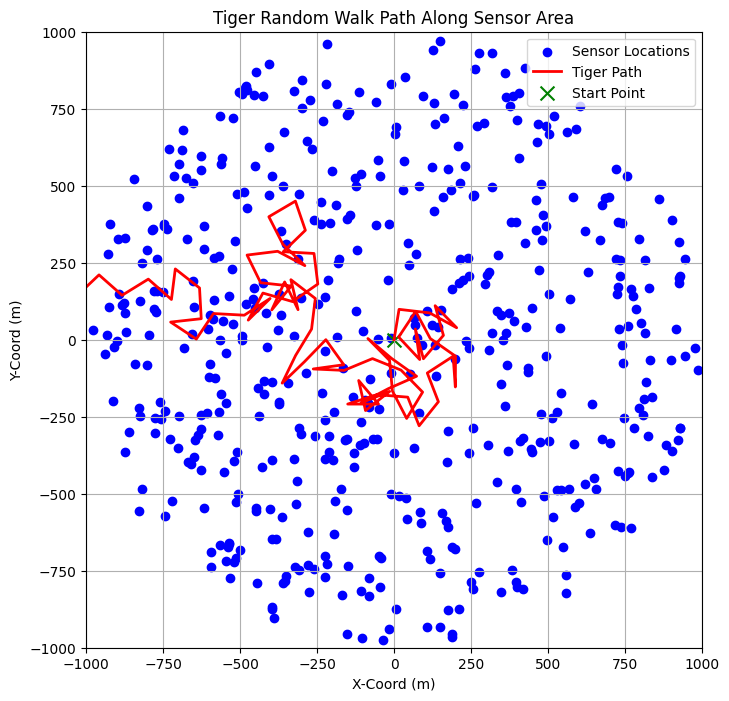

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import numpy as np

# sensors & area radius
num_sensors = 512
radius = 1000

# uniform rand for r and theta
r = np.sqrt(np.random.uniform(0, 1, num_sensors)) * radius  # scale by r
theta = np.random.uniform(0, 2 * np.pi, num_sensors)  # theta b/w (0, 2pi)

# polar to cartesian
x = r * np.cos(theta)
y = r * np.sin(theta)


# u = sensor communication distance (in meters)
u = 100  # placeholder

# compose x, y coordinates
sensor_positions = np.vstack((x, y)).T

# get pairwise distances between sensors
distances = squareform(pdist(sensor_positions))

# define binary adjacency matrix (1 where dist <= u, else 0)
adjacency_matrix = (distances <= u).astype(int)


### --- INSPECT ADJACENCY MATRIX ---------------------------------

print("Adjacency Matrix:\n", adjacency_matrix)
print("\nNumber of connections per sensor:\n", adjacency_matrix.sum(axis=0))

# connections per sensor (i.e., degree of each sensor)
degrees = np.sum(adjacency_matrix, axis=1) 

degree_stats = {
    '\nmean': np.mean(degrees),
    'med': np.median(degrees),
    'min': np.min(degrees),
    'max': np.max(degrees),
    'std': np.std(degrees)
}

s = 100  
radius = 1000 
max_steps = 1000  # safeguard

# perform random walk, check for nearest sensor
def random_walk(sensor_positions, s, radius, max_steps):
    # init tiger at origin
    tiger_position = np.array([0.0, 0.0])
    
    visited_sensors = []
    
    for step in range(max_steps):  
        # check exit cond (tiger has left circle)
        if np.linalg.norm(tiger_position) > radius:
            break
        
        # move in random direction
        angle = np.random.uniform(0, 2 * np.pi) 
        step_vector = np.array([s * np.cos(angle), s * np.sin(angle)])
        tiger_position += step_vector  # Ensure this is a float operation
        
        # get distances from all sensors
        distances = np.linalg.norm(sensor_positions - tiger_position, axis=1)
        
        # get nearest sensor
        nearest_sensor = np.argmin(distances)
        visited_sensors.append(nearest_sensor)
    
    return visited_sensors

sensor_positions = np.vstack((x, y)).T 
visited_sensors = random_walk(sensor_positions, s, radius, max_steps)

print("Visited sensor indices:\n", visited_sensors)
print("\n")

def random_walk(sensor_positions, s, radius, max_steps):
    tiger_position = np.array([0.0, 0.0]) 
    path = [tiger_position.copy()]  # keep tiger path
    
    visited_sensors = []
    
    for step in range(max_steps):  
        if np.linalg.norm(tiger_position) > radius:
            break
        
        # move tiger
        angle = np.random.uniform(0, 2 * np.pi) 
        step_vector = np.array([s * np.cos(angle), s * np.sin(angle)])
        tiger_position += step_vector 
        path.append(tiger_position.copy())
        
        # get distances
        distances = np.linalg.norm(sensor_positions - tiger_position, axis=1)
        
        # get nearest sensor
        nearest_sensor = np.argmin(distances)
        visited_sensors.append(nearest_sensor)
    
    return np.array(path), visited_sensors

path, visited_sensors = random_walk(sensor_positions, s, radius, max_steps)

plt.figure(figsize=(8, 8))
plt.scatter(x, y, c='blue', marker='o', label="Sensor Locations")
plt.plot(path[:, 0], path[:, 1], c='red', label="Tiger Path", linewidth=2)
plt.scatter(path[0, 0], path[0, 1], c='green', marker='x', label="Start Point", s=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-radius, radius)
plt.ylim(-radius, radius)
plt.title('Tiger Random Walk Path Along Sensor Area')
plt.xlabel('X-Coord (m)')
plt.ylabel('Y-Coord (m)')
plt.legend()
plt.grid(True)
plt.show()

## Define the Graph Neural Network (GNN)

### Step Four
*Objective:* 

Define an objective and train a GNN that provides as output for each sensor the probability p(ci=1), where ci∈{1,0} (tiger visited/tiger did not visit).

*Approach:* 

- The problem outlines a **binary classification problem** that aims to predict, for each sensor, the probability p(ci=1) that the tiger did (ci=1) or did not (ci=0) visit the sensor.
- Objective (Loss) function: **Binary Cross-Entropy Loss**
- For **q**, inject label noise to simulate false positives. This will help the GAT handle imperfect sensor data and learn to adjust its predictions based on the false positive rate (i.e., it will learn a correction mechanism to reduce the overall influence of false positives).

Devising the Graph Attention Neural Network (GAT)
---
- **Construct a graph:**
1. Nodes: sensors with their features (position, degree)
2. Edges: connections based on distances between sensors, using s and u
---
- **Define GAT Architecture:**
1. Use the graph with edge features representing sensor distances.
2. Learn u, d, and q as part of the model
---
- **Objective Function:**
- Use binary cross-entropy (BCE) loss with predictions accounting for u, s, and q.
---

#### 4.1. Set up the GAT Architecture

Define the GAT model. This implementation will use edge features based on the distances between sensors (to account for u and s), adding a mechanism to adjust for q (false positives).

- in_channels: number of input features per node (e.g., sensor coordinates or other features)
- out_channels: number of output features for each GAT layer
- edge_dim: dimension of edge features (in this case, the distance between sensors)
- heads: number of attention heads (only using one head, so self-attention)
- GATConv: GAT layer with support for edge features
- fc_q_adjustment: a fully connected layer used to adjust the final output probabilities based on q (false positives)
- edge_attr: edge features passed in, which will be the distances between sensors (d, capturing u and s)

#### 4.2. Forward Pass
Forward performs the forward pass of the GAT, where...
1. GAT layers take node features, adjacency matrix, and edge features
2. ReLU activation is applied to the output of each layer
3. Output is adjusted based on q, using a sigmoid function to produce final probabilities


In [55]:
#!pip install torch_geometric

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GATWithEdgeFeatures(nn.Module):
    def __init__(self, in_channels, out_channels, edge_dim, heads=1):
        super(GATWithEdgeFeatures, self).__init__()
        
        self.gat1 = GATConv(in_channels, out_channels, heads=heads, edge_dim=edge_dim)
        self.gat2 = GATConv(out_channels * heads, out_channels, heads=heads, edge_dim=edge_dim) 
        
        # extra Layer to adjust for q (false pos rate)
        self.fc_q_adjustment = nn.Linear(out_channels, 1)


    # x: node features (sensor features)
    # edge_index: adjacency matrix (COO)
    # edge_attr: edge features (distances between sensors)
    def forward(self, x, edge_index, edge_attr):
        # layer 1
        x = self.gat1(x, edge_index, edge_attr)
        x = F.relu(x) #ReLU activation both layers
        # layer 2
        x = self.gat2(x, edge_index, edge_attr)
        x = F.relu(x)
        # adjust output probabilities (q)
        q_adjustment = torch.sigmoid(self.fc_q_adjustment(x))
        
        output = q_adjustment
        return output


#### 4.3. Graph Construction
Construct a graph, where...
1. *Node Features:* Sensor coordinates (and maybe other features like degree)
2. *Edge Features:* Distances between sensors to represent the edges in the graph
3. *Graph Structure:* Adjacency matrix defines graph's connectivity

In [49]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse

# Step 1: Construct node features
sensor_positions = np.vstack((x, y)).T  # combine x and y into node features
node_features = torch.tensor(sensor_positions, dtype=torch.float)

# Step 2: Define edge features based on distances between sensors
#      adjacency_matrix already defined, get d b/w sensor connections
sensor_positions = torch.tensor(sensor_positions, dtype=torch.float)
distances = torch.cdist(sensor_positions, sensor_positions, p=2)  # pairwise dist

# Step 3: Use adjacency matrix to create edge index
#      (must convert A to COO format for PyTorch_Geom)
adjacency_matrix_torch = torch.tensor(adjacency_matrix, dtype=torch.float)
edge_index, _ = dense_to_sparse(adjacency_matrix_torch) 

# Step 4: Extract edge attributes
edge_attr = distances[edge_index[0], edge_index[1]].unsqueeze(1) 

# Step 5: Construct graph
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)


#### 4.4. Define Training Objective and Incorporate q
- Define the loss function as Binary Cross-Entropy (BCE), and simulate q by injecting noise (false positives) into training labels during training

In [51]:
# BCE loss function for training
criterion = nn.BCELoss()

# use noise to simulate false positives with probability q
def add_noise_to_labels(labels, q):
    noise = torch.rand(labels.shape)
    noisy_labels = torch.where(noise < q, 1 - labels, labels)  # flip label with p(q)
    return noisy_labels

# ground truth labels (0/1, tiger visited/not-visited for each sensor)
true_labels = torch.zeros(node_features.size(0), 1)  # init 0 = no visit
q = 0.1 
noisy_labels = add_noise_to_labels(true_labels, q)

# forward pass
model = GATWithEdgeFeatures(in_channels=2, out_channels=8, edge_dim=1)  # Assuming 2 input features (x, y), 1 edge feature
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

predictions = model(data.x, data.edge_index, data.edge_attr)

# compute loss
loss = criterion(predictions, noisy_labels)


#### 4.5. Visualise the Latent Space

In [50]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, train_mask=None, val_mask=None, test_mask=None):
    # eval mode (Torch)
    model.eval()
    
    # on forward pass, get latent embeddings
    with torch.no_grad():
        node_embeddings = model(data.x, data.edge_index, data.edge_attr)
    
    # reduce D to 2 (2D) (x, y)
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(node_embeddings.cpu().numpy())
    
    plt.figure(figsize=(10, 8))

    if train_mask is not None:
        plt.scatter(latent_2d[train_mask.cpu()], latent_2d[train_mask.cpu()][:, 1], c='blue', label='Train Set')
    if val_mask is not None:
        plt.scatter(latent_2d[val_mask.cpu()], latent_2d[val_mask.cpu()][:, 1], c='green', label='Validation Set')
    if test_mask is not None:
        plt.scatter(latent_2d[test_mask.cpu()], latent_2d[test_mask.cpu()][:, 1], c='red', label='Test Set')
    plt.title('Latent Space Representation')
    plt.legend()
    plt.show()


#### Step 4.6: Implement Training
- Run training over epochs
- Use backprop to minimise BCE-loss
- Update GAT model params based on optimiser
- [monitor training]

---
Interpreting the results:
- Training Loss: Decreases over time, but training losses not substantial
- Val Loss: Fluctuates, but doesn't adhere to a decreasing trend; possible indication of overfitting
- Test Loss: High and stable; indicates poor generalisation

Speculations: 
- GAT may have too much complexity (too many parameters) for the amount/complexity of data, resulting in overfitting 


Epoch [100/1000], Loss: 0.2305
Epoch [200/1000], Loss: 0.1517
Epoch [300/1000], Loss: 0.1491
Epoch [400/1000], Loss: 0.1756
Epoch [500/1000], Loss: 0.1259
Epoch [600/1000], Loss: 0.1365
Epoch [700/1000], Loss: 0.1504
Epoch [800/1000], Loss: 0.1373
Epoch [900/1000], Loss: 0.1269
Epoch [1000/1000], Loss: 0.1476


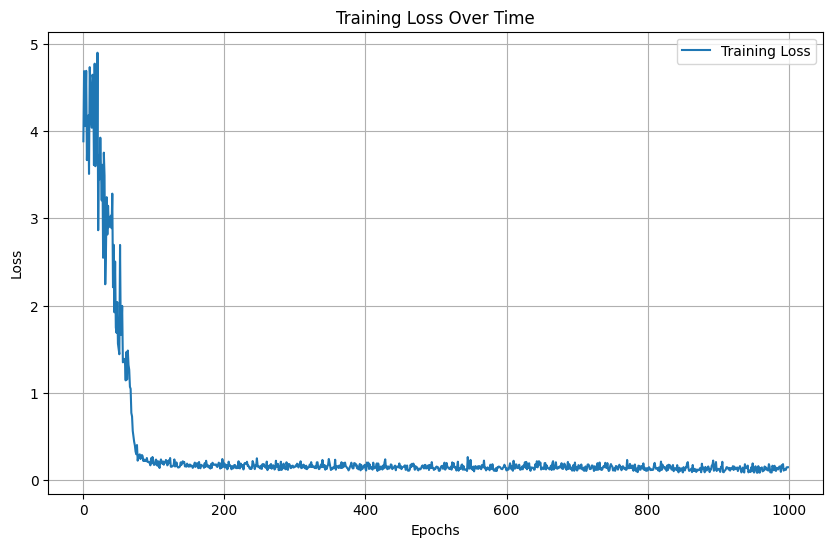

In [66]:
import matplotlib.pyplot as plt

def train_gat(model, data, labels, num_epochs=100, q=0.1, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    loss_history = []

    for epoch in range(num_epochs):
        #train mode (Torch)
        model.train()  
        
        noisy_labels = add_noise_to_labels(labels, q)
        
        # forward pass
        predictions = model(data.x, data.edge_index, data.edge_attr)
        
        # compute loss
        loss = criterion(predictions, noisy_labels)
        
        # backpropagation & optimization
        optimizer.zero_grad()  # wipe grads
        loss.backward()  # compute grads
        optimizer.step()  # update params
        
        loss_history.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return model, loss_history


true_labels = torch.zeros(node_features.size(0), 1)  # no sensors visited initially
true_labels[torch.randint(0, node_features.size(0), (10,))] = 1  

model = GATWithEdgeFeatures(in_channels=2, out_channels=8, edge_dim=1)  # 2 input features (x, y), 1 edge feature
trained_model, loss_history = train_gat(model, data, true_labels, num_epochs=1000, q=0.01, learning_rate=0.01)


plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


Epoch [100/1000], Loss: 1.4281
Epoch [200/1000], Loss: 0.1587
Epoch [300/1000], Loss: 0.1463
Epoch [400/1000], Loss: 0.1396
Epoch [500/1000], Loss: 0.1443
Epoch [600/1000], Loss: 0.1379
Epoch [700/1000], Loss: 0.1446
Epoch [800/1000], Loss: 0.1479
Epoch [900/1000], Loss: 0.1323
Epoch [1000/1000], Loss: 0.1303


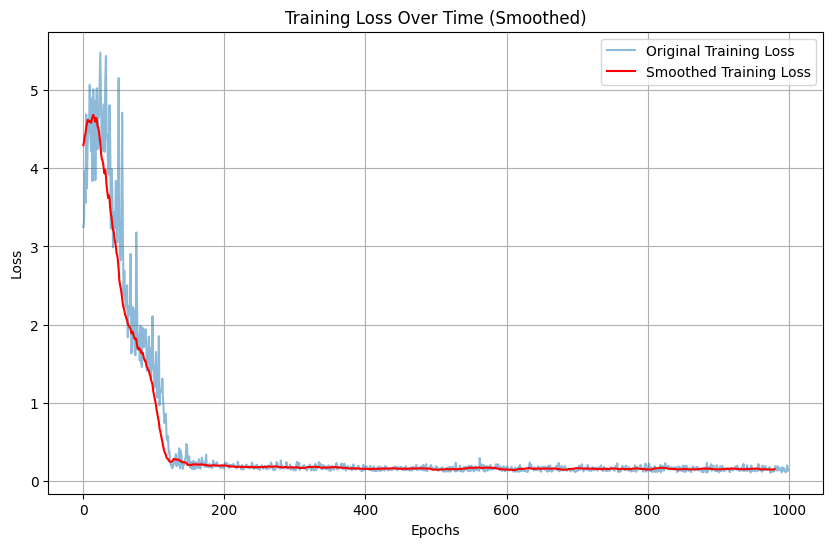

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# smooth with moving average
def smooth_loss(loss_history, smoothing_factor=20):
    smoothed_loss = np.convolve(loss_history, np.ones(smoothing_factor)/smoothing_factor, mode='valid')
    return smoothed_loss

def train_gat(model, data, labels, num_epochs=100, q=0.1, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    loss_history = []

    for epoch in range(num_epochs):
        #train mode (Torch)
        model.train()  
        
        noisy_labels = add_noise_to_labels(labels, q)
        
        # forward pass
        predictions = model(data.x, data.edge_index, data.edge_attr)
        
        # compute loss
        loss = criterion(predictions, noisy_labels)
        
        # backpropagation & optimization
        optimizer.zero_grad()  # wipe grads
        loss.backward()  # compute grads
        optimizer.step()  # update params
        
        loss_history.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return model, loss_history


true_labels = torch.zeros(node_features.size(0), 1)  # no sensors visited initially
true_labels[torch.randint(0, node_features.size(0), (10,))] = 1

model = GATWithEdgeFeatures(in_channels=2, out_channels=8, edge_dim=1)  # 2 input features (x, y), 1 edge feature
trained_model, loss_history = train_gat(model, data, true_labels, num_epochs=1000, q=0.01, learning_rate=0.01)

smoothed_loss = smooth_loss(loss_history)

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Original Training Loss', alpha=0.5)
plt.plot(range(len(smoothed_loss)), smoothed_loss, label='Smoothed Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time (Smoothed)')
plt.legend()
plt.grid(True)
plt.show()


Masking subsets the graph for training (train/test/split).

In [53]:
from sklearn.model_selection import train_test_split

node_indices = torch.arange(data.x.size(0))
train_idx, test_idx = train_test_split(node_indices, test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

# create masks for each set
train_mask = torch.zeros(data.x.size(0), dtype=torch.bool)
val_mask = torch.zeros(data.x.size(0), dtype=torch.bool)
test_mask = torch.zeros(data.x.size(0), dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True


In [18]:
from torch_geometric.utils import subgraph
from torch_geometric.loader import DataLoader
from torch_geometric.utils import add_self_loops, remove_self_loops

def train_gat(model, data, labels, train_mask, val_mask, test_mask, num_epochs=100, q=0.1, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    train_losses, val_losses, test_losses = [], [], []

    for epoch in range(num_epochs):
        model.train()

        noisy_labels = add_noise_to_labels(labels[train_mask], q)

        # clear any existing self-loops
        edge_index, edge_attr = remove_self_loops(data.edge_index, data.edge_attr)

        # add self-loops to the graph
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr, fill_value=1.0, num_nodes=data.x.size(0))

        # subset the graph for train_mask nodes
        train_edge_index, train_edge_attr = subgraph(train_mask, edge_index, edge_attr, relabel_nodes=True)

        # forward pass
        predictions = model(data.x[train_mask], train_edge_index, train_edge_attr)
        loss = criterion(predictions, noisy_labels)

        # backpropagation & optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval() 

        with torch.no_grad():
            # val subset
            val_edge_index, val_edge_attr = subgraph(val_mask, edge_index, edge_attr, relabel_nodes=True)
            val_predictions = model(data.x[val_mask], val_edge_index, val_edge_attr)
            val_loss = criterion(val_predictions, labels[val_mask])
            val_losses.append(val_loss.item())

            # test subset
            test_edge_index, test_edge_attr = subgraph(test_mask, edge_index, edge_attr, relabel_nodes=True)
            test_predictions = model(data.x[test_mask], test_edge_index, test_edge_attr)
            test_loss = criterion(test_predictions, labels[test_mask])
            test_losses.append(test_loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    return train_losses, val_losses, test_losses

train_losses, val_losses, test_losses = train_gat_with_val_test(model, data, true_labels, train_mask, val_mask, test_mask, num_epochs=1000, q=0.01, learning_rate=0.01)


Epoch [100/1000], Train Loss: 0.6542, Val Loss: 0.0000, Test Loss: 0.0004
Epoch [200/1000], Train Loss: 0.9043, Val Loss: 0.0006, Test Loss: 0.0004
Epoch [300/1000], Train Loss: 0.0306, Val Loss: 0.0515, Test Loss: 0.0381
Epoch [400/1000], Train Loss: 0.1718, Val Loss: 0.0110, Test Loss: 0.0115
Epoch [500/1000], Train Loss: 0.0328, Val Loss: 0.0216, Test Loss: 0.0203
Epoch [600/1000], Train Loss: 0.0638, Val Loss: 0.0149, Test Loss: 0.0153
Epoch [700/1000], Train Loss: 0.0068, Val Loss: 0.0088, Test Loss: 0.0091
Epoch [800/1000], Train Loss: 0.1146, Val Loss: 0.0142, Test Loss: 0.0138
Epoch [900/1000], Train Loss: 0.0538, Val Loss: 0.0198, Test Loss: 0.0219
Epoch [1000/1000], Train Loss: 0.0091, Val Loss: 0.0098, Test Loss: 0.0094


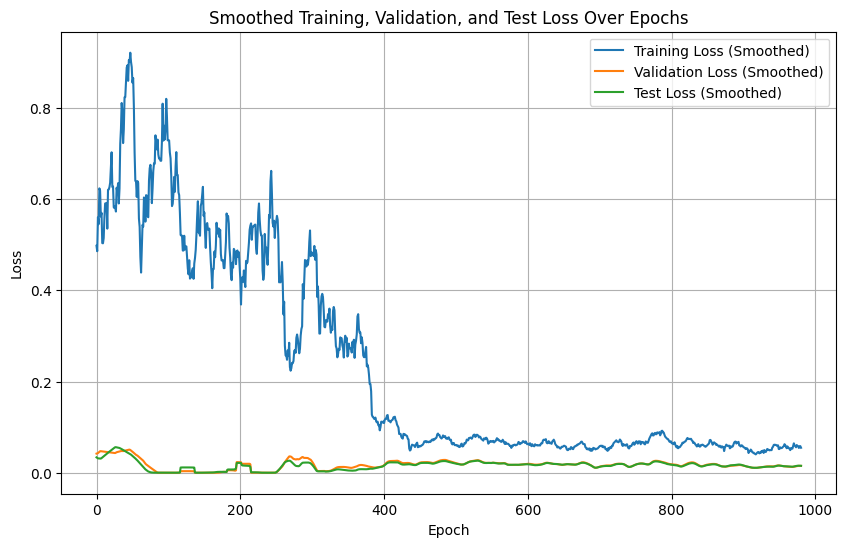

In [21]:
import numpy as np

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# moving average smoothing
smoothed_train_losses = moving_average(train_losses, 20)
smoothed_val_losses = moving_average(val_losses, 20)
smoothed_test_losses = moving_average(test_losses, 20)

# smoothed losses
plt.figure(figsize=(10, 6))
plt.plot(smoothed_train_losses, label='Training Loss (Smoothed)')
plt.plot(smoothed_val_losses, label='Validation Loss (Smoothed)')
plt.plot(smoothed_test_losses, label='Test Loss (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Smoothed Training, Validation, and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


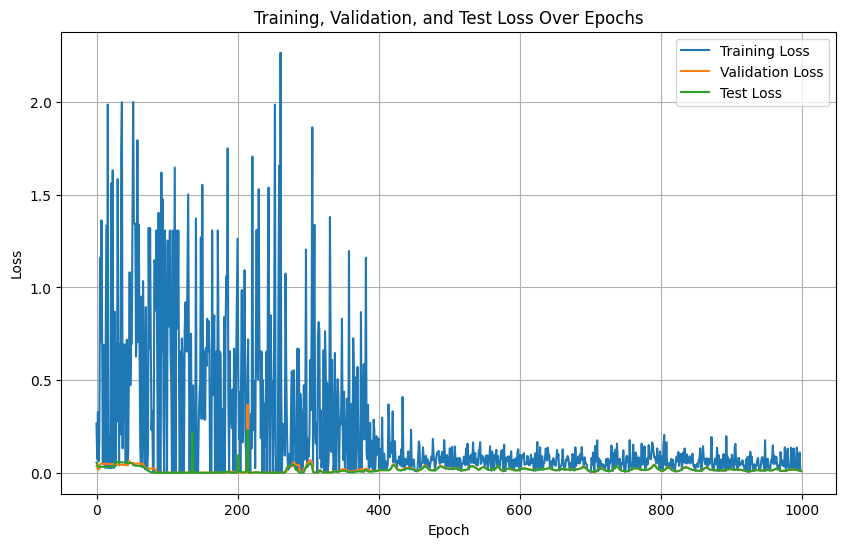

In [19]:
import matplotlib.pyplot as plt

# plot losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Epoch [100/1000]
Epoch [200/1000]
Epoch [300/1000]
Epoch [400/1000]
Epoch [500/1000]
Epoch [600/1000]
Epoch [700/1000]
Epoch [800/1000]
Epoch [900/1000]
Epoch [1000/1000]


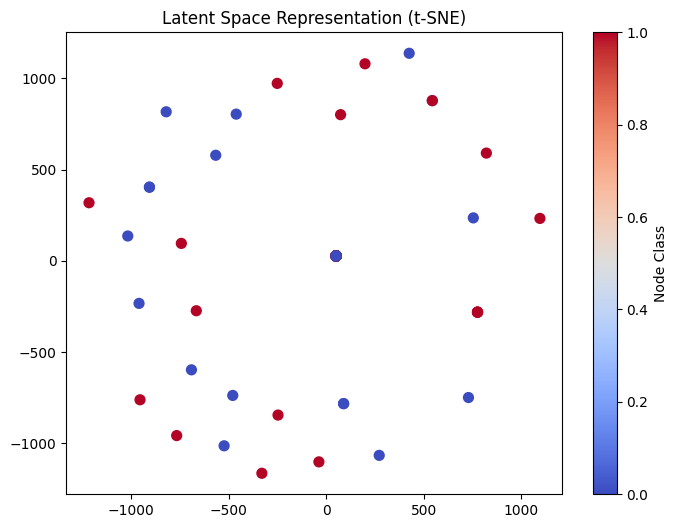

In [57]:
#visualise latent space (training set)
visualize_latent_space(model, data)

In [15]:
#print(predictions)  # Check what probabilities are being output by the model


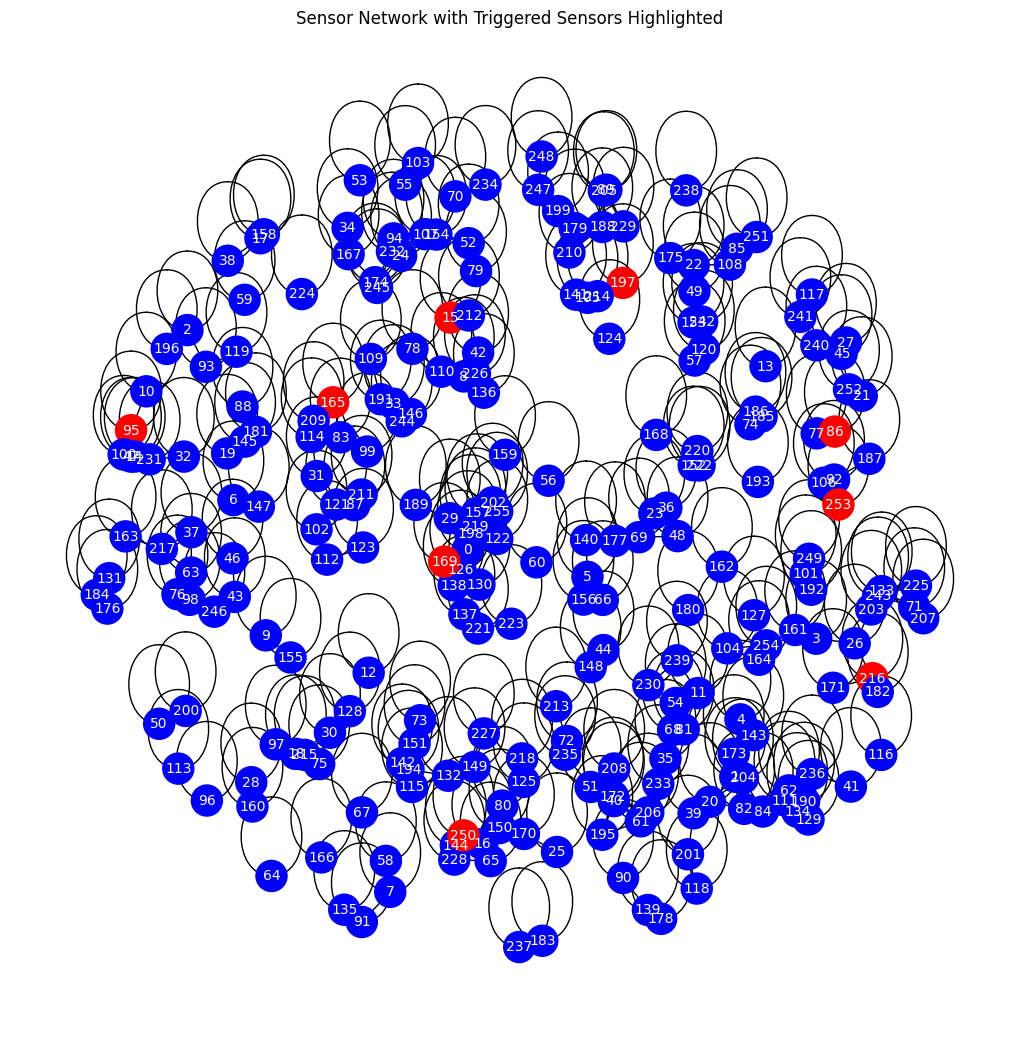

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

# get sensor positions
sensor_positions = data.x[:, :2].detach().cpu().numpy() 

# get edge indices for graph structure
edge_index = data.edge_index.detach().cpu().numpy()

# get predictions (after training)
#     use a threshold probability for sensor trigger (e.g., probability > 0.3)
model.eval()  
with torch.no_grad():
    predictions = model(data.x, data.edge_index, data.edge_attr)  #output for all sensors

triggered_sensors = (predictions > 0.3).cpu().numpy()  # conv to binary (triggered or not)

# networkx from edge index
G = nx.Graph()
for i, j in zip(edge_index[0], edge_index[1]): #COO-format
    G.add_edge(i, j)

node_colors = ['red' if triggered_sensors[i] else 'blue' for i in range(len(sensor_positions))]

plt.figure(figsize=(10, 10))
nx.draw(G, pos=sensor_positions, node_color=node_colors, with_labels=True, node_size=500, font_size=10, font_color='white')
plt.title('Sensor Network with Triggered Sensors Highlighted')
plt.show()


### Debugging attempts

In [ ]:
# Approach #1 to reduce GNN complexity... CRASHES KERNEL x_x

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# single head and reduced hidden units
class GATReducedComplexity(torch.nn.Module):
    def __init__(self, in_channels, out_channels, edge_dim):
        super(GATReducedComplexity, self).__init__()
        
        # reduce hidden size (e.g., 64)
        self.hidden_units = 64

        # GATConv layer - signle attention head and reduced hidden units
        self.conv1 = GATConv(in_channels, self.hidden_units, heads=1, concat=True, edge_dim=edge_dim)
        
        # output GATConv layer
        self.conv2 = GATConv(self.hidden_units, out_channels, heads=1, concat=False, edge_dim=edge_dim)

    def forward(self, x, edge_index, edge_attr):
       
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.conv2(x, edge_index, edge_attr)

        return torch.sigmoid(x)


in_channels = 2  # x and y sensor coords
out_channels = 1  # binary classification (i.e., visited tiger or no)
edge_dim = 1  # edge feature dimes (e.g., distance)

# init model (reduced complexity)
model = GATReducedComplexity(in_channels, out_channels, edge_dim)

# Train the model and get losses
train_losses, val_losses, test_losses = train_gat_with_val_test(model, data, true_labels, train_mask, val_mask, test_mask, num_epochs=1000, q=0.01, learning_rate=0.01)

# Example initialization of the new model
in_channels = 2  # For example, x and y sensor coordinates
out_channels = 1  # Binary classification (visited by tiger or not)
edge_dim = 1  # Edge feature dimension (e.g., distance)

# Initialize the new model
model = GATReducedComplexity(in_channels, out_channels, edge_dim)

# Train the model and get losses
train_losses, val_losses, test_losses = train_gat_with_val_test(model, data, true_labels, train_mask, val_mask, test_mask, num_epochs=1000, q=0.01, learning_rate=0.01)


In [ ]:
# Approach #2 to reduce GNN complexity... CRASHES KERNEL x_x

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import subgraph
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')

radius = 1000
n_sensors = 256
n_steps = 1000
d = 50  
u = 200  
q = 0.1  
s = 20  
n_epochs = 200

def generate_sensor_positions(n_sensors, radius):
    angles = np.random.uniform(0, 2 * np.pi, n_sensors)
    radii = np.sqrt(np.random.uniform(0, radius ** 2, n_sensors))
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.stack([x, y], axis=1)

def compute_adjacency(sensor_positions, u):
    distances = np.linalg.norm(sensor_positions[:, None, :] - sensor_positions[None, :, :], axis=-1)
    adjacency = (distances <= u).astype(np.float32)
    return adjacency

def simulate_random_walk(n_steps, s, sensor_positions, d):
    position = np.array([0.0, 0.0])
    sensor_triggers = np.zeros(n_sensors)
    
    for _ in range(n_steps):
        angle = np.random.uniform(0, 2 * np.pi)
        step = np.array([s * np.cos(angle), s * np.sin(angle)])
        position += step

        distances_to_sensors = np.linalg.norm(sensor_positions - position, axis=-1)
        triggered_sensors = distances_to_sensors <= d
        sensor_triggers = np.maximum(sensor_triggers, triggered_sensors)
        
    false_positives = np.random.rand(n_sensors) < q
    sensor_triggers = np.maximum(sensor_triggers, false_positives)
    
    return sensor_triggers



###########

class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, out_channels, heads=2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=heads, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)


def prepare_data(n_sensors, radius, u, d, s, n_steps):
    sensor_positions = generate_sensor_positions(n_sensors, radius)
    adjacency_matrix = compute_adjacency(sensor_positions, u)

    edge_index = np.array(np.nonzero(adjacency_matrix))
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    
    labels = simulate_random_walk(n_steps, s, sensor_positions, d) 
    node_features = torch.tensor(sensor_positions, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
    
    return node_features, edge_index, labels

    
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

    
def validate(model, data, criterion):
    model.eval()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    return loss.item()

    
def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


# 80/10/10
def split_data(data, n_train, n_val):
    train_mask = torch.arange(0, n_train)
    val_mask = torch.arange(n_train, n_train + n_val)
    test_mask = torch.arange(n_train + n_val, data.x.size(0))
    
    train_edge_index, _ = subgraph(train_mask, data.edge_index, relabel_nodes=True)
    val_edge_index, _ = subgraph(val_mask, data.edge_index, relabel_nodes=True)
    test_edge_index, _ = subgraph(test_mask, data.edge_index, relabel_nodes=True)
    
    train_data = Data(x=data.x[train_mask], edge_index=train_edge_index, y=data.y[train_mask])
    val_data = Data(x=data.x[val_mask], edge_index=val_edge_index, y=data.y[val_mask])
    test_data = Data(x=data.x[test_mask], edge_index=test_edge_index, y=data.y[test_mask])
    
    return train_data, val_data, test_data

def main():
    # generate data
    node_features, edge_index, labels = prepare_data(n_sensors, radius, u, d, s, n_steps)
    data = Data(x=node_features, edge_index=edge_index, y=labels)
    
    # split
    n_train = int(0.8 * n_sensors)
    n_val = int(0.1 * n_sensors)
    
    train_data, val_data, test_data = split_data(data, n_train, n_val)
    
    # init
    model = GAT(num_features=2, hidden_channels=64, out_channels=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.BCELoss()

    train_loss = []
    val_loss = []

    # train
    for epoch in range(n_epochs):
        loss = train(model, train_data, optimizer, criterion)
        val_loss_epoch = validate(model, val_data, criterion)
        
        train_loss.append(loss)
        val_loss.append(val_loss_epoch)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {loss}, Val Loss = {val_loss_epoch}")
    
    # plot
    plot_loss(train_loss, val_loss)

    # test
    test_loss = validate(model, test_data, criterion)
    print(f"Test Loss = {test_loss}")

if __name__ == "__main__":
    main()



Epoch 0: Train Loss = 1.260188102722168, Val Loss = 4.841156005859375


C:\Users\maria\anaconda3\envs\JaxFlax-DLEnviron\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0: Train Loss = 4.843116760253906, Val Loss = 0.6419335603713989
Epoch 10: Train Loss = 17.047393798828125, Val Loss = 8.655001640319824
Epoch 20: Train Loss = 34.51084518432617, Val Loss = 58.35280227661133
Epoch 30: Train Loss = 22.746963500976562, Val Loss = 0.2713683843612671
Epoch 40: Train Loss = 17.912128448486328, Val Loss = 33.384246826171875


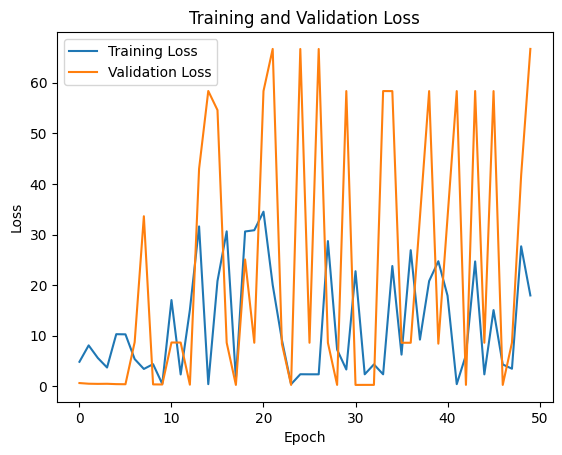

Test Loss = 28.675586700439453


In [2]:
# Batch Training: Approach #3, Trying to reduce GNN complexity... kind of runs? mostly crashes.. :( 

#### Implement Batch-Norm in Training
#  Can batch multiple graphs into a single batch for parallel processing (best to use subgraphs)
#  "Since learned parameters are the same for all nodes, we can learn the parameters using sub-graphs or entirely different graphs." (Lecture Notes)
#  That is, can also split the graph into subgraphs or use batches of sensor nodes
#  When handling node and edge batches, each batch has its own subset of nodes and edges, so what's passed is batches of node features, edge indices, and edge features.

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import subgraph
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')

radius = 1000
n_sensors = 128 
n_steps = 500   
d = 50  
u = 200  
q = 0.1 
s = 20 
n_epochs = 50  
batch_size = 32 

def generate_sensor_positions(n_sensors, radius):
    angles = np.random.uniform(0, 2 * np.pi, n_sensors)
    radii = np.sqrt(np.random.uniform(0, radius ** 2, n_sensors))
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.stack([x, y], axis=1)


def compute_adjacency(sensor_positions, u):
    distances = np.linalg.norm(sensor_positions[:, None, :] - sensor_positions[None, :, :], axis=-1)
    adjacency = (distances <= u).astype(np.float32)
    return adjacency


def simulate_random_walk(n_steps, s, sensor_positions, d):
    position = np.array([0.0, 0.0]) 
    sensor_triggers = np.zeros(n_sensors)
    
    for _ in range(n_steps):
        angle = np.random.uniform(0, 2 * np.pi)
        step = np.array([s * np.cos(angle), s * np.sin(angle)])
        position += step

        distances_to_sensors = np.linalg.norm(sensor_positions - position, axis=-1)
        triggered_sensors = distances_to_sensors <= d
        sensor_triggers = np.maximum(sensor_triggers, triggered_sensors)
        
    false_positives = np.random.rand(n_sensors) < q
    sensor_triggers = np.maximum(sensor_triggers, false_positives)
    
    return sensor_triggers


def prepare_data(n_sensors, radius, u, d, s, n_steps):
    sensor_positions = generate_sensor_positions(n_sensors, radius)
    adjacency_matrix = compute_adjacency(sensor_positions, u)

    edge_index = np.array(np.nonzero(adjacency_matrix))
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    
    labels = simulate_random_walk(n_steps, s, sensor_positions, d)
    node_features = torch.tensor(sensor_positions, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    return node_features, edge_index, labels


def split_data(data, n_train, n_val):
    train_mask = torch.arange(0, n_train)
    val_mask = torch.arange(n_train, n_train + n_val)
    test_mask = torch.arange(n_train + n_val, data.x.size(0))
    
    train_edge_index, _ = subgraph(train_mask, data.edge_index, relabel_nodes=True)
    val_edge_index, _ = subgraph(val_mask, data.edge_index, relabel_nodes=True)
    test_edge_index, _ = subgraph(test_mask, data.edge_index, relabel_nodes=True)
    
    train_data = Data(x=data.x[train_mask], edge_index=train_edge_index, y=data.y[train_mask])
    val_data = Data(x=data.x[val_mask], edge_index=val_edge_index, y=data.y[val_mask])
    test_data = Data(x=data.x[test_mask], edge_index=test_edge_index, y=data.y[test_mask])
    
    return train_data, val_data, test_data



##########

class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, out_channels, heads=2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=heads, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)

# train with batching
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# val with batching
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index)
            loss = criterion(out, batch.y)
            total_loss += loss.item()
    return total_loss / len(loader)


def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

def main():

    node_features, edge_index, labels = prepare_data(n_sensors, radius, u, d, s, n_steps)
    data = Data(x=node_features, edge_index=edge_index, y=labels)

    n_train = int(0.8 * n_sensors)
    n_val = int(0.1 * n_sensors)
    train_data, val_data, test_data = split_data(data, n_train, n_val)
    
    model = GAT(num_features=2, hidden_channels=64, out_channels=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.BCELoss()

    train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
    val_loader = DataLoader([val_data], batch_size=batch_size)
    test_loader = DataLoader([test_data], batch_size=batch_size)

    train_loss = []
    val_loss = []

    # train in batches
    for epoch in range(n_epochs):
        loss = train(model, train_loader, optimizer, criterion)
        val_loss_epoch = validate(model, val_loader, criterion)
        
        train_loss.append(loss)
        val_loss.append(val_loss_epoch)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {loss}, Val Loss = {val_loss_epoch}")
    
    plot_loss(train_loss, val_loss)
    test_loss = validate(model, test_loader, criterion)
    print(f"Test Loss = {test_loss}")

if __name__ == "__main__":
    main()
